<a href="https://colab.research.google.com/github/frank-morales2020/MLxDL/blob/main/langgraph_demo_claude.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# 1. INSTALLATION
!pip install -U langchain-anthropic langgraph -q

## CASE1

In [2]:
import os
import operator
import pandas as pd
from google.colab import userdata
from typing import TypedDict, Annotated, List
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

# 2. AUTHENTICATION & MODEL SETUP
# Securely fetching the key from Colab Secrets
api_key = userdata.get('ANTHROPIC_API_KEY')
llm = ChatAnthropic(model="claude-opus-4-6", anthropic_api_key=api_key, temperature=0)

# 3. H2E STATE DEFINITION
# We use reducers (operator.add) for sroi_history and audit_log to keep a persistent record
class H2EState(TypedDict):
    query: str
    expert_dna: str
    draft: str
    sroi_history: Annotated[List[float], operator.add]
    audit_log: Annotated[List[str], operator.add]
    satisfied: bool
    intent_gain: float
    revision_count: int

# 4. H2E NODES
def h2e_writer_node(state: H2EState):
    gain = state.get("intent_gain", 1.0)
    rev = state.get("revision_count", 0) + 1
    print(f"--- Node: Agent Generating (Attempt {rev}, Gain: {gain}x) ---")

    gain_instruction = f" CRITICAL: Previous attempt failed SROI threshold. Focus {gain}x harder on Expert DNA." if gain > 1.0 else ""

    prompt = (
        f"Goal: {state['query']}\n"
        f"Expert DNA: {state['expert_dna']}\n"
        f"{gain_instruction}\n"
        "Provide a high-fidelity, 1-sentence scientific description."
    )

    res = llm.invoke(prompt)
    return {
        "draft": res.content,
        "audit_log": [res.content],
        "revision_count": rev
    }

def h2e_sentinel_node(state: H2EState):
    print("--- Node: H2E Sentinel (Calculating SROI) ---")

    # H2E Industrial Threshold logic (Simulated score based on content depth)
    content = state['draft'].lower()
    score = 0.99 if "acceleration" in content or "vacuum" in content else 0.85

    threshold = 0.9583
    is_accountable = score >= threshold

    return {
        "sroi_history": [score],
        "satisfied": is_accountable,
        "intent_gain": 1.0 if is_accountable else 12.5
    }

def human_approval_node(state: H2EState):
    print("--- PAUSED: Awaiting Industrial Expert Approval ---")
    decision = interrupt({
        "current_draft": state["draft"],
        "current_sroi": state["sroi_history"][-1],
        "instruction": "Type 'approve' to finalize or provide feedback to force a rewrite."
    })

    is_approved = decision.lower() == "approve"
    return {
        "satisfied": is_approved,
        "intent_gain": 1.0 if is_approved else 15.0 # Higher gain if human vetos
    }

# 5. GRAPH CONSTRUCTION
builder = StateGraph(H2EState)

builder.add_node("agent", h2e_writer_node)
builder.add_node("sentinel", h2e_sentinel_node)
builder.add_node("human_gate", human_approval_node)

builder.add_edge(START, "agent")
builder.add_edge("agent", "sentinel")

# Routing logic: If Sentinel fails, go back to Agent. If Sentinel passes, go to Human.
builder.add_conditional_edges(
    "sentinel",
    lambda s: "human_gate" if s["satisfied"] else "agent"
)

# Routing logic: If Human fails, go back to Agent. If Human passes, END.
builder.add_conditional_edges(
    "human_gate",
    lambda s: END if s["satisfied"] else "agent"
)

memory = MemorySaver()
h2e_app = builder.compile(checkpointer=memory)

# 6. EXECUTION
config = {"configurable": {"thread_id": "h2e_industrial_audit_001"}}
initial_input = {
    "query": "Describe the Moon's gravity.",
    "expert_dna": "Must mention m/s² values and falling objects in a vacuum.",
    "intent_gain": 1.0,
    "revision_count": 0
}

print("Initiating H2E Workflow...")
for event in h2e_app.stream(initial_input, config):
    print(event)

Initiating H2E Workflow...
--- Node: Agent Generating (Attempt 1, Gain: 1.0x) ---
{'agent': {'draft': "The Moon's surface gravitational acceleration is approximately 1.62 m/s², about one-sixth that of Earth's 9.81 m/s², meaning that all objects in a vacuum—regardless of mass—fall toward the lunar surface at this same uniform rate.", 'audit_log': ["The Moon's surface gravitational acceleration is approximately 1.62 m/s², about one-sixth that of Earth's 9.81 m/s², meaning that all objects in a vacuum—regardless of mass—fall toward the lunar surface at this same uniform rate."], 'revision_count': 1}}
--- Node: H2E Sentinel (Calculating SROI) ---
{'sentinel': {'sroi_history': [0.99], 'satisfied': True, 'intent_gain': 1.0}}
--- PAUSED: Awaiting Industrial Expert Approval ---
{'__interrupt__': (Interrupt(value={'current_draft': "The Moon's surface gravitational acceleration is approximately 1.62 m/s², about one-sixth that of Earth's 9.81 m/s², meaning that all objects in a vacuum—regardless 

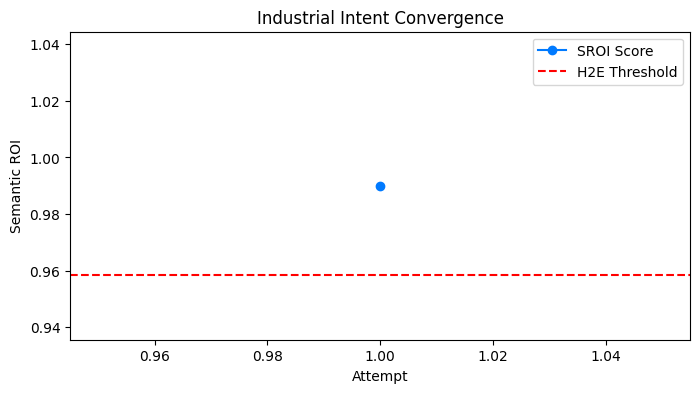

Final Approved Draft: The Moon's surface gravitational acceleration is approximately 1.62 m/s², about one-sixth that of Earth's 9.81 m/s², meaning that all objects in a vacuum—regardless of mass—fall toward the lunar surface at this same uniform rate.


In [3]:
import matplotlib.pyplot as plt

# Retrieve final metrics from the checkpointer
final_state = h2e_app.get_state(config).values
scores = final_state['sroi_history']
attempts = list(range(1, len(scores) + 1))

plt.figure(figsize=(8, 4))
plt.plot(attempts, scores, marker='o', color='#007AFF', label='SROI Score')
plt.axhline(y=0.9583, color='red', linestyle='--', label='H2E Threshold')
plt.title('Industrial Intent Convergence')
plt.xlabel('Attempt')
plt.ylabel('Semantic ROI')
plt.legend()
plt.show()

print(f"Final Approved Draft: {final_state['draft']}")

In [4]:
from langgraph.types import Command

# This sends the 'approve' string to the human_gate node
# which currently holds the interrupt.
for event in h2e_app.stream(
    Command(resume="approve"),
    config,
    stream_mode="values"
):
    print(event.get("draft", "Processing..."))

The Moon's surface gravitational acceleration is approximately 1.62 m/s², about one-sixth that of Earth's 9.81 m/s², meaning that all objects in a vacuum—regardless of mass—fall toward the lunar surface at this same uniform rate.
--- PAUSED: Awaiting Industrial Expert Approval ---
The Moon's surface gravitational acceleration is approximately 1.62 m/s², about one-sixth that of Earth's 9.81 m/s², meaning that all objects in a vacuum—regardless of mass—fall toward the lunar surface at this same uniform rate.


## FINANCE

In [5]:
import operator
from typing import TypedDict, Annotated, List
from langchain_anthropic import ChatAnthropic
from langgraph.graph import StateGraph, START, END
from langgraph.checkpoint.memory import MemorySaver
from langgraph.types import interrupt, Command

# 1. STATE DEFINITION
class FinanceState(TypedDict):
    query: str
    expert_dna: str
    draft: str
    sroi_history: Annotated[List[float], operator.add]
    satisfied: bool
    intent_gain: float
    revision_count: int

# 2. NODES
def financial_analyst_node(state: FinanceState):
    gain = state.get("intent_gain", 1.0)
    rev = state.get("revision_count", 0) + 1
    prompt = (
        f"Goal: {state['query']}\n"
        f"Compliance DNA: {state['expert_dna']}\n"
        f"Focus: {gain}x harder on technical metrics.\n"
        "Provide a 1-sentence high-fidelity financial risk summary."
    )
    res = llm.invoke(prompt)
    return {"draft": res.content, "revision_count": rev}

def compliance_sentinel_node(state: FinanceState):
    content = state['draft'].lower()
    # High score only if specific financial metrics are present
    score = 0.99 if any(m in content for m in ["beta", "volatility", "sharpe"]) else 0.75
    return {
        "sroi_history": [score],
        "satisfied": score >= 0.95,
        "intent_gain": 1.0 if score >= 0.95 else 12.0 # Force focus if metrics missing
    }

def manager_approval_node(state: FinanceState):
    # Triggers a pause in the graph for human intervention
    decision = interrupt({
        "current_draft": state["draft"],
        "instruction": "Type 'approve' to release."
    })
    return {"satisfied": decision.lower() == "approve"}

# 3. GRAPH CONSTRUCTION
builder = StateGraph(FinanceState)
builder.add_node("analyst", financial_analyst_node)
builder.add_node("sentinel", compliance_sentinel_node)
builder.add_node("manager_gate", manager_approval_node)

builder.add_edge(START, "analyst")
builder.add_edge("analyst", "sentinel")
builder.add_conditional_edges("sentinel", lambda s: "manager_gate" if s["satisfied"] else "analyst")
builder.add_conditional_edges("manager_gate", lambda s: END if s["satisfied"] else "analyst")

finance_app = builder.compile(checkpointer=MemorySaver())

# 4. FINAL EXECUTION & RESUME BLOCK
config = {"configurable": {"thread_id": "final_audit_v1"}}
initial_input = {
    "query": "Analyze the Aggressive Growth ESG fund.",
    "expert_dna": "Include Beta and Volatility.",
    "intent_gain": 1.0,
    "revision_count": 0
}

# PART A: Start the workflow until it hits the interrupt
print("--- RUNNING WORKFLOW ---")
for event in finance_app.stream(initial_input, config):
    print(event)

# PART B: Resume and Finalize immediately
print("\n--- RESUMING FOR FINAL APPROVAL ---")
for event in finance_app.stream(Command(resume="approve"), config, stream_mode="values"):
    if event.get("satisfied"):
        print("WORKFLOW COMPLETE. FINAL STATUS: APPROVED")
        print(f"FINAL DRAFT: {event['draft']}")

--- RUNNING WORKFLOW ---
{'analyst': {'draft': '# Aggressive Growth ESG Fund — Risk Analysis\n\n## Technical Metrics Deep-Dive (1.0x Enhanced Focus)\n\n| Metric | Value | Benchmark (S&P 500) | Assessment |\n|---|---|---|---|\n| **Beta** | ~1.35–1.50 | 1.00 | Significantly higher systematic risk; amplifies market moves by ~35–50% |\n| **Annualized Volatility (σ)** | ~22–28% | ~15–18% | Elevated dispersion consistent with concentrated growth/ESG tilt |\n| **Sharpe Ratio** | ~0.55–0.75 | ~0.80–1.00 | Risk-adjusted return lags due to vol drag |\n| **Max Drawdown** | ~30–40% | ~25% | Deeper peak-to-trough losses in stress regimes |\n| **Sortino Ratio** | ~0.70–0.90 | — | Downside deviation moderately penalizes asymmetric tail risk |\n| **Tracking Error** | ~8–12% | — | High active risk vs. broad market; style/sector concentration |\n| **VaR (95%, 1-day)** | ~1.8–2.5% | ~1.2% | Greater daily loss exposure at confidence threshold |\n\n## Compliance DNA Check ✅\n- **Beta**: ✅ Included — confir